# Here plot activity not averaged over time for each poke

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [15]:
from mecll.rsync import Rsync_aligner
from mecll.load import load_data
from mecll.process_data.proc_beh import build_poke_df, get_in_task_pokes

# From pycontrol

#  Helper functions

In [4]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [5]:
def get_transitions_state(graph_type):
    
    transitions = [[i,i+1] for i in range(8)]
    transitions.extend([[i,i-1] for i in range(1,9)])
    if graph_type=='loop':
        transitions.extend([[0,8],[8,0]])
        
    all_transitions = []
    for kk, pk in enumerate(transitions):
        all_transitions.append(str(pk[0])+'_'+str(pk[1]))
    return all_transitions

In [6]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512,mx=None,mn=None):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        cmap_ = 'RdBu_r'
        if mx is None: mx = np.max(spks)
            
        if mn is None: mn = 0
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn,vmax=mx,clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            G.add_node(i,pos=poke_pos[i],color=cmap.to_rgba(c))
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    #print(all_transitions)
    for e in all_transitions:
        #print(all_transitions)
        G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        #G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=False,
                #node_labels=sequence
        )
        label_seq = dict([(i,seq_inv[i]) for i in range(9)])
        nx.draw_networkx_labels(G,poke_pos, label_seq)

    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=False)
        label_seq = dict([(seq_inv[i],i) for i in range(9)])
        pos_ = nx.drawing.layout.circular_layout(G)
        nx.draw_networkx_labels(G,pos_, label_seq)


In [7]:
def build_poke_df(lines,events,sync_thing=0):
    
    df = pd.DataFrame(columns=['target','port','state','task_nr','direction','in_timeout','n_timeouts','probe','correct',
                               'previous_port','previous_state','reward','block_nr','task_repeat_nr','port_repeat','next_correct',
                               'frac_corr','RT','time','current_sequence','graph_type' #behavioural variables
                              ]) 
    
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    current_block_number = -1
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            #if poke_dict is not None:
            #    all_poke_dict.append(cp.deepcopy(poke_dict))
            #poke_dict = {}
            current_block_number += 1
            current_task = re.findall(r'task_number([0-9])',l)[0]
            current_sequence = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            current_graph_type = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]
            #poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            #poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            #poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            if len(df)>1:
                previous_port = df.iloc[-1]['port']
                if not df.iloc[-1]['correct']:
                    current_is_repeat = True
                    df.loc[len(df)-2,'next_correct'] = False

                else:
                    current_is_repeat = False
                    df.loc[len(df)-2,'next_correct'] = True

            else:
                previous_port = None
                current_is_repeat = False
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            
                
                
            
            #print(current_sequence)
            if len(rew_hist)>2:
                poke_dct = {
                          'target': int(target),
                          'port': int(poke),
                          'state': current_sequence.index(int(poke)),
                          'task_nr': current_task,
                          'direction': direction,
                          'in_timeout': False,
                          'n_timeouts': np.nan,
                          'probe': probe,
                          'correct': poke==target,
                          'reward': n_rew==rew_hist[-2],
                          'block_nr':current_block_number,
                          'task_repeat_nr': int(np.floor(current_block_number/2)),
                          'frac_corr': None,
                          'RT':None,
                          'time':t_,
                          'current_sequence': current_sequence,
                          'graph_type': current_graph_type,
                          'port_repeat':current_is_repeat,
                                  }
                df = df.append(poke_dct,ignore_index=True)

       
    return df
    

In [8]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            #print(poke,target)
            if len(target_hist)>3:
                if (poke==target and 
                    #target!=target_hist[-2] and 
                    n_rew_in_seq>5 and
                    direction==1 and
                    n_rew==rew_hist[-2] and
                    probe==False):
                    #print(poke)
                    if poke in poke_dict.keys():
                        poke_dict[poke].append(t_)
                    else:
                        poke_dict[poke] = [t_]
                    #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

In [9]:
def plot_cell(ix,all_resps_g1,all_resps_g2,all_poke_dict,norm=False,norm_pct=90):
    plt.figure(figsize=(12,4))
    n_plot = 1
    ctr = 0
    resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
    resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]

    if norm:
        mx = np.percentile(np.concatenate([all_resps_g1[ix],all_resps_g2[ix]]),norm_pct)
    else:
        mx = None
    plt.subplot(n_plot,4,4*ctr+1)
    spks = all_resps_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',mx=mx)
    plt.subplot(n_plot,4,4*ctr+2)
    spks = all_resps1_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='poke',mx=mx)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='state',mx=mx)
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='state',mx=mx)
    
    ctr +=1

# Actual code

In [11]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

df = build_poke_df(lines,events)


567 567


In [16]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [17]:
def get_task_boudaries(lines,aligner):
    change_task_event = eval(lines[7][2:])['change_task']
    
    task_boundaries = []
    has_start = False
    for l in lines:
        
        if not has_start:
            if 'D'==l[0]:
                t_ = float(re.findall(r'D ([0-9]*)\s',l)[0])
                if np.isfinite(aligner.B_to_A(t_)):
                    print('1')
                    task_boundaries.append(aligner.B_to_A(t_))
                    has_start = True


        if 'change_task_start' in l:
            t_ = float(re.findall(r'P ([0-9]*)\s',l)[0])
            task_boundaries.append(aligner.B_to_A(t_))
            #print(l)
            #print(t_)
            
    for l in lines[::-1]:
        if l[0]=='D':
            t_  = float(re.findall(r'D ([0-9]*)\s',l)[0])
            if np.isfinite(aligner.B_to_A(t_)):
                print('2')
                task_boundaries.append(aligner.B_to_A(t_))
                break
    task_boundaries = (np.array(task_boundaries)/30.).astype('int')
    return task_boundaries

In [18]:
task_boundaries = get_task_boudaries(lines,aligner)

1
2


In [19]:
def build_spike_array(single_units,spkT,spkC):

    nUnits = len(single_units)
    maxT = int(np.ceil(np.max(spkT/30.)))
    spike_array = np.zeros([nUnits,maxT])
    for ctr,unit in enumerate(single_units):
        spike_times = (np.floor(spkT[spkC==unit]/30.)).astype('int')
        spike_array[ctr,spike_times] = 1
    return spike_array
    

In [21]:
from scipy.ndimage import gaussian_filter1d

In [22]:
def smooth_spike_array(spke_array,sigma=10):
    spike_smooth = []
    for i in spike_array:
        spike_smooth.append(gaussian_filter1d(i,sigma))


    spike_smooth = np.array(spike_smooth)
    return spike_smooth

In [23]:
#I think this works as a downsampling thing. This is now downsampled to 100ms
def down_sample_spikes(spike_array,factor=50):
    #factor = 50
    n_units = spike_array.shape[0]
    n_timepoints = spike_array.shape[1]
    mx_ = int(np.floor(n_timepoints/factor)*factor)
    spike_array_downsample = np.reshape(spike_array[:,:mx_],[n_units,int(mx_/factor),factor]).sum(axis=2)
    return spike_array_downsample

In [25]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   #(df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        
        #if port_nr==8:
            #poke_dict_t1['task_nr'] = str(task_nr)
            #poke_dict_t2['task_nr'] = str(task_nr)
            #poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            #poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            #poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            #poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]




0 15 0
0 17 1
0 27 2
0 20 3
0 23 4
0 7 5
0 22 6
0 21 7
0 20 8


In [26]:
def get_all_resps(aligner,poke_dict,single_units,spkT,spkC,window0=3000,window1=6000,get_time_mean=True):
    """ This code gets the average response of all cells to pokes in a single task block
    """
    all_resps = []
    all_resps1 = []
    all_resps2 = []
    scaleF = (window0+window1)/30000.
    
    for unit in single_units:#[n_:n_+1]:  #loop over all cells
        
        spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
        
        resps = [[] for _ in range(9)]
        resps1 = [[] for _ in range(9)]
        resps2 = [[] for _ in range(9)]
        for key,vals in poke_dict.items():  #loop over pokes
            if re.findall('[0-9]',key): #ignore dictionary items that are metadata like the sequence and graph time
                aligned_T = aligner.B_to_A(vals) #align pokes into spike times

                #get the spikes that are in bounds for position encoding
                pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
                
                used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
                key = int(key)
                half_npks = int(len(used_pks)/2)
                #print(key,half_npks)
                for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                    
                    #this is a block of code to split the data in half, useful for looking at stability when you
                    #only have one task block
                    
                    spike_locs = np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1))
                    if get_time_mean:
                        nSpikes = len(np.where(spike_locs)[0])
                        firing_rate = scaleF*float(nSpikes)
                    else:
                        spikes = np.zeros(window0+window1)
                        spikes[spk_unit[spike_locs]-tpk] = 1
                        firing_rate = spikes.copy()
                    
                    if pk_ix<=half_npks:
                        resps2[key].append(firing_rate)
                        
                    else:
                        resps1[key].append(firing_rate)

                    resps[key].append(firing_rate)

                    
                    
        all_resps.append(resps.copy())
        all_resps1.append(resps1.copy())
        all_resps2.append(resps2.copy())
        
    return all_resps, [all_resps1,all_resps2]

In [27]:
window0 = 12000
window1 = 12000
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,get_time_mean=False,window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,get_time_mean=False,window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [32]:
np.array(all_resps1_g1_single_trial).shape

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(201, 9)

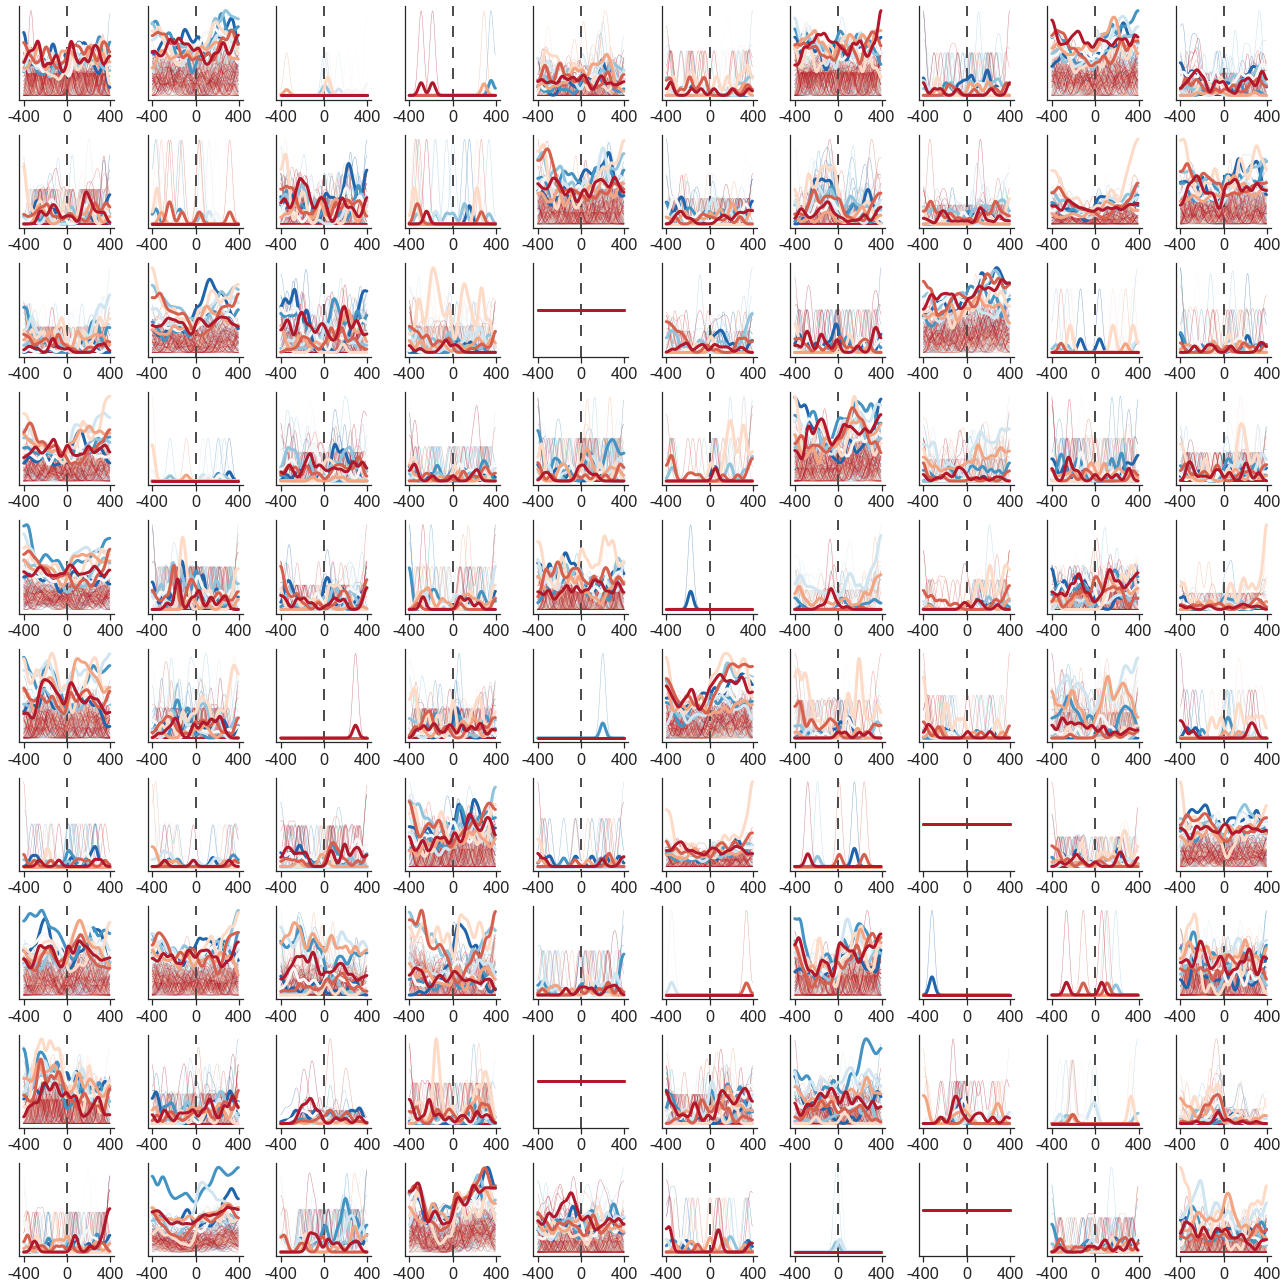

In [33]:
n_neurons = len(all_resps1_g1_single_trial)

plt.figure(figsize=(18,18))
x = np.arange((window0 + window1)/150)

offset = 0
clrs_plot = seaborn.color_palette('RdBu_r',n_colors=9)
for neuron in np.arange(100):
    plt.subplot(10,10, neuron+1)
    for poke_nr in range(9):
        activity = np.array(all_resps_g1_single_trial[offset+neuron][poke_nr])
        if len(activity)>0:
            for single_trial_activity in activity:
                single_trial_activity = gaussian_filter1d(single_trial_activity.reshape(-1,150).mean(axis=1),5)
                plt.plot(x/200,single_trial_activity,color=clrs_plot[poke_nr],linewidth=.5,alpha=.5)

            mean_activity = np.mean(activity,axis=0)
            mean_activity = gaussian_filter1d(mean_activity.reshape(-1,150).mean(axis=1),5)
            plt.plot(x/200,mean_activity*3,color=clrs_plot[poke_nr],linewidth=3,zorder=100)
            plt.axvline(x=window0/150/200,color='.3',dashes=(7,7))
            seaborn.despine()
            plt.xticks([0,.4,.8],[-400,0,400])
            plt.yticks([])
plt.tight_layout()